# Сценарий

Для сценария есть смысл получать кварталы буквально на этапе создания сценария.

ВАЖНО:

- Кварталы сценария получаем для выбранного `scenario_id`.
- Стараемся работать в `crs` от `project_gdf`.

In [1]:
from blocksnet.config import log_config

log_config.set_logger_level('WARNING')

In [2]:
SCENARIO_ID = 1134

In [3]:
from prostor.fetchers import scenarios

PROJECT_ID = scenarios.get_scenario(SCENARIO_ID)['project']['project_id']
PROJECT_ID

73

In [4]:
from prostor.fetchers import projects

BASE_SCENARIO_ID = projects.get_project(PROJECT_ID)['base_scenario']['id']
BASE_SCENARIO_ID

124

## Вспомогательный код

Метод `close_gaps` необходим для дружбы геометрий дорог, которые граничат рядом но не соприкасаются на перекрестках точь-в-точь.

Так как мы не хотим цеплять всю библиотеку `momepy` ради одного метода, мы просто честно его скопируем.

In [5]:
import shapely
import geopandas as gpd
import numpy as np

def close_gaps(gdf, tolerance): # taken from momepy
    geom = gdf.geometry.array
    coords = shapely.get_coordinates(geom)
    indices = shapely.get_num_coordinates(geom)

    edges = [0]
    i = 0
    for ind in indices:
        ix = i + ind
        edges.append(ix - 1)
        edges.append(ix)
        i = ix
    edges = edges[:-1]
    points = shapely.points(np.unique(coords[edges], axis=0))

    buffered = shapely.buffer(points, tolerance / 2)

    dissolved = shapely.union_all(buffered)

    exploded = [
        shapely.get_geometry(dissolved, i)
        for i in range(shapely.get_num_geometries(dissolved))
    ]

    centroids = shapely.centroid(exploded)

    snapped = shapely.snap(geom, shapely.union_all(centroids), tolerance)

    return gpd.GeoSeries(snapped, crs=gdf.crs)

## Основная работа

### 1. Получение нужных геометрий

#### 1.1. Границы территории

<Axes: >

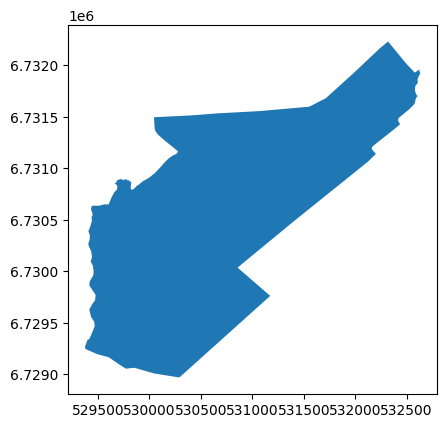

In [6]:
from prostor.fetchers import projects

def get_project_boundaries(project_id : int) -> gpd.GeoDataFrame:
    geometry = projects.get_project_geometry(project_id)
    gdf = gpd.GeoDataFrame(geometry=[geometry], crs=4326)
    crs = gdf.estimate_utm_crs()
    return gdf.to_crs(crs)

project_gdf = get_project_boundaries(PROJECT_ID)

project_gdf.plot()

#### 1.2. Дороги

<Axes: >

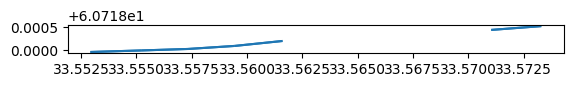

In [7]:
import pandas as pd
from prostor.fetchers import scenarios

ROADS_POF_ID = 26

def get_roads_gdf(scenario_id : int, base_scenario_id : int) -> gpd.GeoDataFrame:
    gdfs = []
    try:
        user_roads_gdf = scenarios.get_physical_objects(scenario_id, physical_object_function_id=26)
        gdfs.append(user_roads_gdf)
    except:
        print('No USER roads')
    try:
        base_roads_gdf = scenarios.get_physical_objects(base_scenario_id, physical_object_function_id=26)
        gdfs.append(base_roads_gdf)
    except:
        print('No BASE roads')
    
    if len(gdfs) == 0:
        return None
    return pd.concat(gdfs).reset_index(drop=True)

roads_gdf = get_roads_gdf(SCENARIO_ID, BASE_SCENARIO_ID)
roads_gdf.plot()

#### 1.4. Водные объекты

In [8]:
WATER_POF_ID = 4

try:
    water_gdf = scenarios.get_physical_objects(SCENARIO_ID, physical_object_function_id=WATER_POF_ID)
except:
    print('No USER water')
    water_gdf = None

water_gdf

No USER water


### 2. Генерация слоя городских кварталов

#### 2.1. Препроцессинг урбан объектов

In [9]:
from blocksnet.blocks.cutting import preprocess_urban_objects

roads_gdf = roads_gdf.to_crs(project_gdf.crs)
if water_gdf is not None:
    water_gdf = water_gdf.to_crs(project_gdf.crs)

lines_gdf, polygons_gdf = preprocess_urban_objects(roads_gdf, None, water_gdf)

2025-10-13 01:36:13.136 | WARNING  | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:53 - Creating empty railways
2025-10-13 01:36:13.139 | WARNING  | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:60 - Creating empty water


#### 2.2. Нарезка кварталов

- Делаем линиям `close_gaps`, чтобы не было проблем с неточным рисованием.
- Делаем границам буфер `-1`, чтобы всякие линии точно достали. 

2025-10-13 01:36:13.171 | WARNING  | blocksnet.blocks.cutting.processing.schemas:validate_and_preprocess_gdfs:64 - Creating empty polygon objects
2025-10-13 01:36:13.173 | WARNING  | blocksnet.blocks.cutting.processing.schemas:validate_and_preprocess_gdfs:71 - Creating empty buildings


<Axes: >

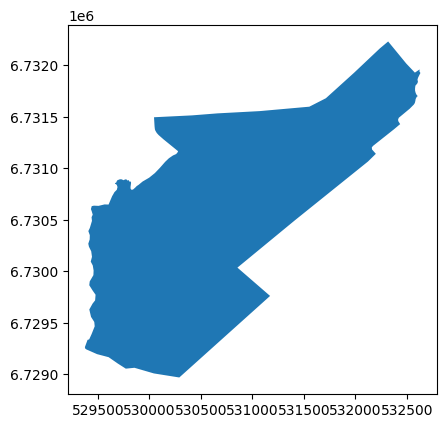

In [10]:
from blocksnet.blocks.cutting import cut_urban_blocks

lines_gdf.geometry = close_gaps(lines_gdf, 1)
project_gdf.geometry = project_gdf.geometry.buffer(-1)

blocks_gdf = cut_urban_blocks(project_gdf, lines_gdf, polygons_gdf)

blocks_gdf.plot()

### 3. Присвоение функциональных назначений

<Axes: >

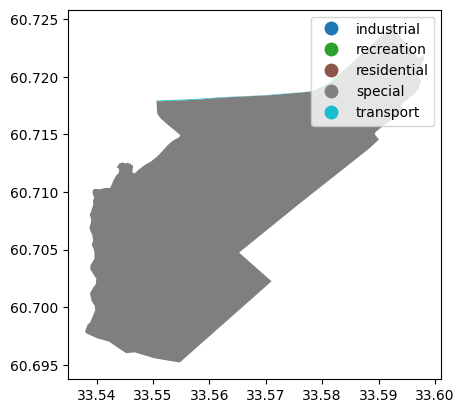

In [11]:
import pandas as pd
from prostor.adapters import adapt_functional_zones

SOURCES_PRIORITY = ['User', 'PZZ', 'OSM']

def _get_best_functional_zones_source(sources_df : pd.DataFrame) -> tuple[int | None, str | None]:
    sources = sources_df['source'].unique()
    for source in SOURCES_PRIORITY:
        if source in sources:
            sources_df = sources_df[sources_df['source'] == source]
            year = sources_df.year.max()
            return int(year), source
    return None, None #FIXME ??? 

def get_context_functional_zones(scenario_id : int) -> gpd.GeoDataFrame:
    sources_df = scenarios.get_functional_zones_sources(scenario_id)
    year, source = _get_best_functional_zones_source(sources_df)
    functional_zones = scenarios.get_functional_zones(scenario_id, year, source)
    return adapt_functional_zones(functional_zones)

functional_zones_gdf = get_context_functional_zones(SCENARIO_ID)

functional_zones_gdf.plot('functional_zone', legend=True)

In [12]:
from blocksnet.blocks.assignment import assign_land_use
from prostor.adapters import LAND_USE_RULES

functional_zones_gdf = functional_zones_gdf.to_crs(blocks_gdf.crs)

land_use_gdf = assign_land_use(blocks_gdf, functional_zones_gdf, LAND_USE_RULES)

land_use_gdf.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share
0,"POLYGON ((529877.655 6730826.811, 529893.716 6...",0.000044,0.0,0.001737,0.000368,0.001101,0.996723,0.0,LandUse.SPECIAL,0.996723


<Axes: >

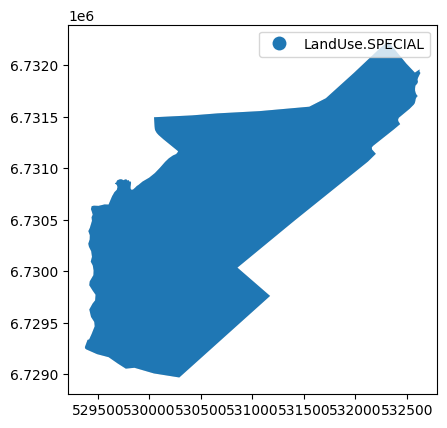

In [13]:
ax = land_use_gdf.plot(color='#ddd')
land_use_gdf.plot('land_use', ax=ax, legend=True)

In [14]:
blocks_gdf = blocks_gdf.join(land_use_gdf.drop(columns=['geometry']))

### 4. Присвоение параметров зданий

In [15]:
from prostor.adapters import adapt_buildings
from blocksnet.preprocessing.imputing import impute_buildings

LIVING_BUILDING_POT_ID = 4

def get_context_buildings(scenario_id : int):
    gdf = scenarios.get_physical_objects(scenario_id, physical_object_type_id=LIVING_BUILDING_POT_ID, centers_only=True)
    gdf = adapt_buildings(gdf.reset_index(drop=True))
    crs = gdf.estimate_utm_crs()
    return impute_buildings(gdf.to_crs(crs)).to_crs(4326)

try:
    buildings_gdf = get_context_buildings(SCENARIO_ID)
    buildings_gdf.head()
except:
    print('No USER buildings')
    buildings_gdf = None

No USER buildings


Если все-таки здания есть, агрегируем. В случае чего на этапе соединения с контекстом уберем пропуски.

In [16]:
from blocksnet.blocks.aggregation import aggregate_objects

if buildings_gdf is not None:
    buildings_agg_gdf,_ = aggregate_objects(blocks_gdf, buildings_gdf.to_crs(blocks_gdf.crs))
    buildings_agg_gdf.head()
else:
    buildings_agg_gdf = None

In [17]:
if buildings_agg_gdf is not None:
    buildings_agg_gdf.plot('population', legend=True)

In [18]:
if buildings_agg_gdf is not None:
    blocks_gdf = blocks_gdf.join(buildings_agg_gdf.drop(columns=['geometry']).rename(columns={'count': 'count_buildings'}))

### 4. Получение слоев сервисов

In [19]:
service_types_df = pd.read_pickle('data/service_types.pickle')
service_types_df.head()

,capacity_modeled,infrastructure_type,weight,radius_availability_meters,time_availability_minutes,services_per_1000_normative,services_capacity_per_1000_normative,soc_value_ids,blocksnet
service_type_id,,,,,,,,,
1,2000.0,basic,0.2,None,30.0,NaN,150.0,[8],park
2,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None
3,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None
4,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None
5,NaN,comfort,0.5,None,60.0,NaN,64.0,None,beach


Сперва получаем все сервисы по контексту

In [20]:
services_gdf = scenarios.get_services(SCENARIO_ID, centers_only=True)

services_gdf.head(3)

,geometry,service_type,territory_type,name,capacity,is_capacity_real,territories,properties,created_at,updated_at,object_geometry_id,address,osm_id,is_scenario_service,is_scenario_geometry
service_id,,,,,,,,,,,,,,,
589486,POINT (33.56314 60.70941),"{'service_type_id': 82, 'urban_function': {'id...",None,Лодейное Поле,10000,False,"[{'id': 117, 'name': 'Лодейнопольское городско...","{'name': 'Лодейное Поле', 'osm_id': '2239489',...",2024-10-10T19:03:16.790570Z,2024-10-10T19:03:16.790570Z,586274,None,None,False,False


Адаптируем их к инпуту, разбивая `gpd.GeoDataFrame` на `dict[int, gpd.GeoDataFrame]` (ключи = `service_type_id`)

In [21]:
def adapt_service_types(services_gdf : gpd.GeoDataFrame, service_types_df : pd.DataFrame) -> dict[int, gpd.GeoDataFrame]:
    gdfs = {}
    service_types_ids = services_gdf.apply(lambda s : s['service_type']['service_type_id'], axis=1)
    for service_type_id, row in service_types_df.iterrows():
        mask = service_types_ids == service_type_id
        gdf = services_gdf[mask][['geometry','capacity']].copy()
        if gdf.capacity.isna().any(): # если есть пробелы, пробуем заполнять
            fill_value = row['capacity_modeled']
            if fill_value is None:
                fill_value = gdf.capacity.mean()
            gdf.capacity = gdf.capacity.fillna(fill_value)
        gdfs[service_type_id] = gdf
    return gdfs

services_gdfs = adapt_service_types(services_gdf, service_types_df)

services_gdfs.keys()

dict_keys([1, 2, 3, 4, 5, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 143, 144])

Назначаем кварталам

In [22]:
from blocksnet.blocks.aggregation import aggregate_objects

for service_type_id, gdf in services_gdfs.items():
    agg_gdf,_ = aggregate_objects(blocks_gdf, gdf.to_crs(blocks_gdf.crs))
    agg_gdf = agg_gdf.drop(columns=['geometry'])
    columns = {c:f'{c}_{service_type_id}' for c in agg_gdf.columns}
    agg_gdf = agg_gdf.rename(columns=columns)
    blocks_gdf = blocks_gdf.join(agg_gdf)

## Результат

В результате получаем слой со столбцами со всех этапов пайплайна:
- **Геометрии кварталов**.
- **Функциональное зонирование** -- доли `residential`, `recreation` и тд, а также наибольший `land_use` и его доля `share`
- **Параметры зданий** -- `population`, `build_floor_area`, `buildings_count` и тд.
- **Параметры сервисов** -- `capacity_{service_type_id}` и `count_{service_type_id}`

In [23]:
blocks_gdf.to_pickle('./data/scenario_blocks.pickle')

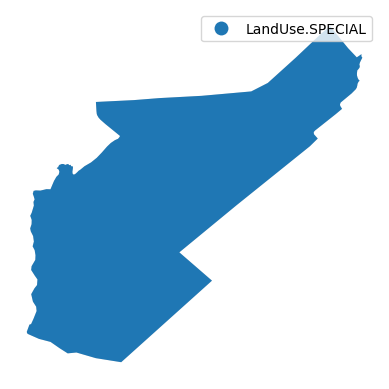

In [24]:
ax = blocks_gdf.plot(color='#ddd')
blocks_gdf.plot(column='land_use', ax=ax, legend=True).set_axis_off()